In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Data Loading

This notebook shows how to load and prepare data into the machine-learning pipeline with ``AUCMEDI``.  
``AUCMEDI`` provides functions to load data from ``directory``, from ``csv`` and from ``json``. 

Here, we will load the data from disc after downloading them from the web.

## Downloading the data

In [2]:
cwd = !pwd
datadir = cwd[0] + "/data"

from pathlib import Path

Path(datadir).mkdir(parents=True, exist_ok=True)

#import wget

#print('Beginning file download with wget module')

#url = 'https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1'
#wget.download(url, datadir)

# unzip the data

#import zipfile
#with zipfile.ZipFile("data/Kather_texture_2016_image_tiles_5000.zip","r") as zip_ref:
#    zip_ref.extractall("data")

Now we have downloaded our data and unzipped them.  
The way these data come, pictures of each class are in stored in a seperate folder, like so:

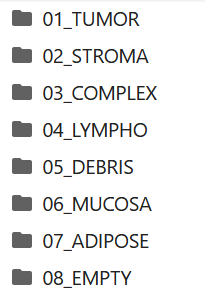

This is pretty useful, because we can directly use the folder-structure to load the corresponding labels to the data.

## Preparing the data for aucmedi

As mentioned, the ``input_interface`` of ``AUCMEDI`` reads the data and labels from ``directory``, from ``csv`` or from ``json``. Here we are going to read them from ``directory``.  
The ``input_interface`` gives back some useful information that we are going to use later.

In [3]:
from aucmedi.data_processing.io_data import input_interface
ds_loader = input_interface("directory", path_imagedir="data/Kather_texture_2016_image_tiles_5000", path_data=None, training=True, ohe=False)
(samples, class_ohe, nclasses, class_names, image_format) = ds_loader

2022-07-20 14:01:40.078899: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Now that we have loaded the data, we can proceed as usual...  

This means, first defining a train, validation and test-set, then defining the model, training it and finally evaluating it. If you have questions on these steps have a look in the corresponding notebooks.

## Continue as usual...

In [4]:
from aucmedi.sampling.split import sampling_split
train, validation, test = sampling_split(samples, class_ohe, sampling=[0.5, 0.25, 0.25], stratified=True, iterative=False, seed=123)

## Define the model

In [5]:
from aucmedi.neural_network.model import NeuralNetwork
import tensorflow_addons as tfa

f1Score = tfa.metrics.F1Score(num_classes=nclasses, threshold=0.5)


model = NeuralNetwork(n_labels=nclasses, channels=3, loss="categorical_crossentropy", metrics=["categorical_accuracy", f1Score], activation_output="softmax")

2022-07-20 14:01:42.239830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 14:01:42.918555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22844 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:3f:00.0, compute capability: 7.5


## Train the model

In [6]:
from aucmedi.data_processing.data_generator import DataGenerator

train_generator = DataGenerator(samples=train[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                               resize=model.meta_input, standardize_mode=model.meta_standardize,
                                               labels=train[1], image_format=image_format, batch_size=32, data_aug=None, 
                                               grayscale=False, subfunctions=[], prepare_images=False, 
                                               sample_weights=None, seed=123, workers=1)
val_generator = DataGenerator(samples=validation[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                             resize=model.meta_input, standardize_mode=model.meta_standardize,
                                             labels=validation[1], image_format=image_format, batch_size=32, data_aug=None, 
                                             grayscale=False, subfunctions=[], prepare_images=False, 
                                             sample_weights=None, seed=123, workers=1)

history = model.train(training_generator=train_generator, validation_generator=val_generator, epochs=20, iterations=None, 
                                         callbacks=None, class_weights=None, transfer_learning=False)

Epoch 1/20


2022-07-20 14:01:45.280497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-20 14:01:45.859370: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


79/79 [==============================] - 16s 167ms/step - loss: 1.7129 - categorical_accuracy: 0.3220 - f1_score: 0.1070 - val_loss: 1.2427 - val_categorical_accuracy: 0.5424 - val_f1_score: 0.2240
Epoch 2/20
79/79 [==============================] - 13s 158ms/step - loss: 1.1525 - categorical_accuracy: 0.5488 - f1_score: 0.3559 - val_loss: 0.9272 - val_categorical_accuracy: 0.6400 - val_f1_score: 0.4257
Epoch 3/20
79/79 [==============================] - 12s 150ms/step - loss: 0.9381 - categorical_accuracy: 0.6476 - f1_score: 0.5254 - val_loss: 0.7728 - val_categorical_accuracy: 0.7248 - val_f1_score: 0.6069
Epoch 4/20
79/79 [==============================] - 13s 158ms/step - loss: 0.8466 - categorical_accuracy: 0.6748 - f1_score: 0.6024 - val_loss: 0.6912 - val_categorical_accuracy: 0.7632 - val_f1_score: 0.6910
Epoch 5/20
79/79 [==============================] - 12s 153ms/step - loss: 0.7308 - categorical_accuracy: 0.7260 - f1_score: 0.6669 - val_loss: 0.6169 - val_categorical_accura

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.validation.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


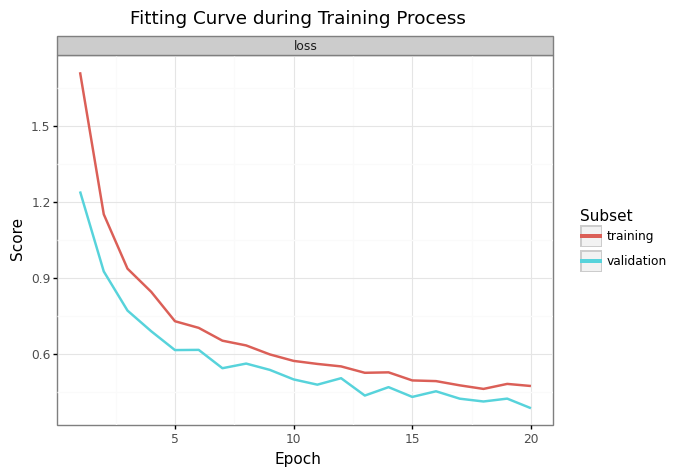

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.fitting_course.accuracy.png


/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


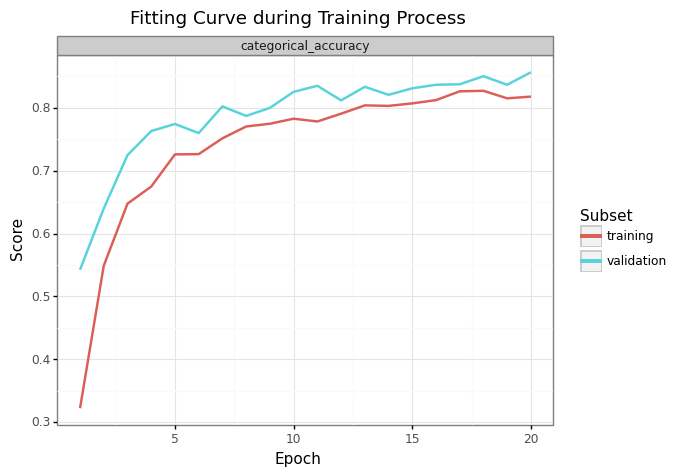

In [7]:
from aucmedi import *
from aucmedi.evaluation.fitting import *

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["loss"],
    prefix_split=".",
    suffix="validation",
    show=True
)

evaluate_fitting(
    train_history = history,
    out_path = "./",
    monitor=["accuracy"],
    prefix_split=".",
    suffix="accuracy",
    show=True
)

In [8]:
from aucmedi.data_processing import data_generator

predict_generator = data_generator.DataGenerator(samples=test[0], path_imagedir="data/Kather_texture_2016_image_tiles_5000",
                                                 resize=model.meta_input, standardize_mode=model.meta_standardize,
                                                 labels=None, image_format=image_format, batch_size=32, data_aug=None, 
                                                 shuffle=False, grayscale=False, subfunctions=[], prepare_images=False, 
                                                 sample_weights=None, seed=123, workers=1)



In [9]:
prediction = model.predict(prediction_generator=predict_generator)

40/40 [==============================] - 4s 92ms/step


/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.barplot.png
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/main/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.

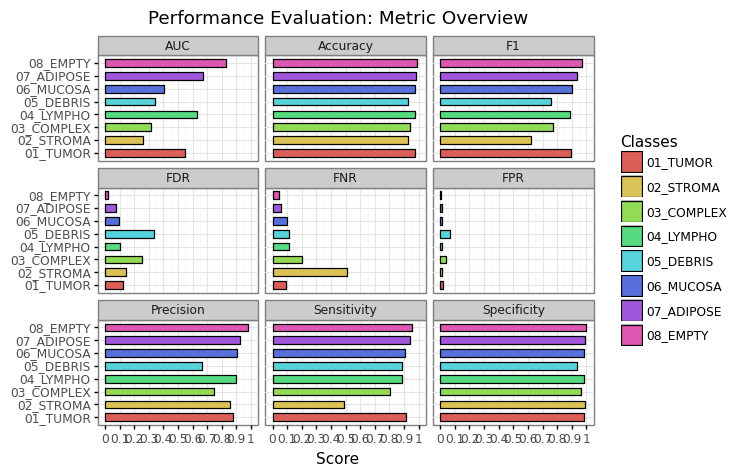

/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.confusion_matrix.png


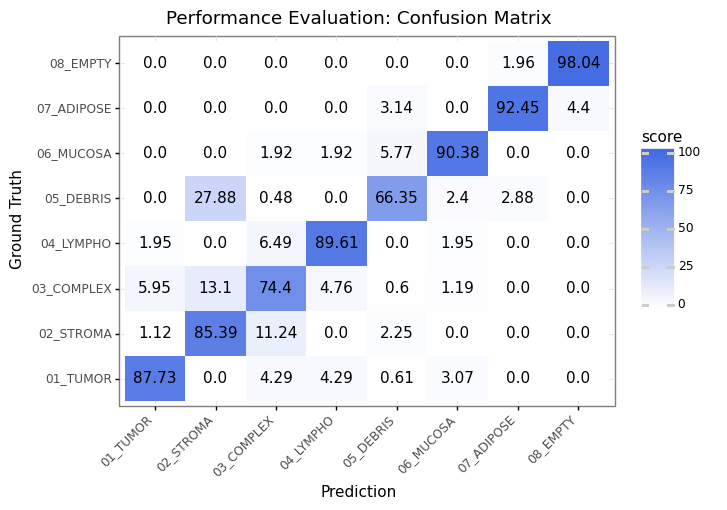

/home/main/.local/lib/python3.8/site-packages/aucmedi/evaluation/performance.py:236: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 9 in image.
/home/main/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./plot.performance.roc.png


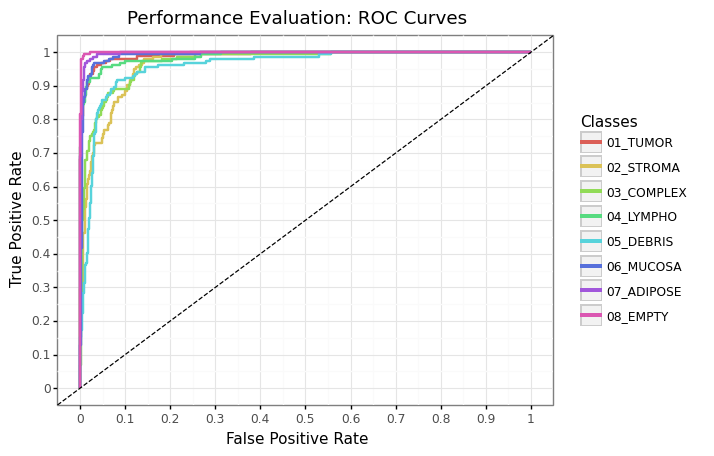

,metric,score,class
0,TP,143.000000,01_TUMOR
1,TN,1073.000000,01_TUMOR
2,FP,20.000000,01_TUMOR
3,FN,14.000000,01_TUMOR
4,Sensitivity,0.910828,01_TUMOR
...,...,...,...
99,FNR,0.044586,08_EMPTY
100,FDR,0.019608,08_EMPTY
101,Accuracy,0.992000,08_EMPTY
102,F1,0.967742,08_EMPTY


In [10]:
from aucmedi import *
from aucmedi.evaluation.performance import *

evaluate_performance(prediction, test[1], out_path="./", class_names=class_names, show=True)